In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, expr, desc, sqrt, mean, stddev, percentile_approx, last, coalesce
from pyspark.sql.types import DoubleType, DateType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("NetflixStockPreprocessing") \
    .getOrCreate()

In [3]:
# Create directory for plots if it doesn't exist
os.makedirs('distribution_plots', exist_ok=True)

In [4]:
# Function for detailed outlier analysis
def comprehensive_outlier_detection(spark_df, numeric_columns):
    outlier_results = {}

OUTLIER

In [5]:
# Function for detailed outlier analysis
def comprehensive_outlier_detection(spark_df, numeric_columns):
    outlier_results = {}
    
    # Convert to pandas for visualization
    pandas_df = spark_df.toPandas()
    
    # Create a figure for boxplots
    plt.figure(figsize=(15, 6))
    
    # Analyze each numeric column
    for idx, column in enumerate(numeric_columns, 1):
        # Calculate statistics using Spark
        stats = spark_df.select(
            mean(col(column)).alias('mean'),
            stddev(col(column)).alias('stddev'),
            expr(f'percentile_approx({column}, array(0.25, 0.75), 10000)').alias('quartiles')
        ).collect()[0]
        
        # Extract values
        q1 = float(stats['quartiles'][0])
        q3 = float(stats['quartiles'][1])
        iqr = q3 - q1
        
        # Define bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Count outliers using Spark
        outliers_count = spark_df.filter(
            (col(column) < lower_bound) | (col(column) > upper_bound)
        ).count()
        
        # Get outlier rows
        outliers = spark_df.filter(
            (col(column) < lower_bound) | (col(column) > upper_bound)
        ).toPandas()
        
        # Store results
        outlier_results[column] = {
            'total_outliers': outliers_count,
            'percentage_outliers': (outliers_count / spark_df.count()) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers': outliers
        }
        
        # Print detailed outlier information
        print(f"\nOutlier Analysis for {column}:")
        print(f"Total Outliers: {outliers_count}")
        print(f"Percentage of Outliers: {(outliers_count / spark_df.count()) * 100:.2f}%")
        print(f"Lower Bound: {lower_bound}")
        print(f"Upper Bound: {upper_bound}")
        
        # If there are outliers, print them
        if outliers_count > 0:
            print("\nOutlier Details:")
            print(outliers)
        
        # Create boxplot
        plt.subplot(1, len(numeric_columns), idx)
        sns.boxplot(x=pandas_df[column])
        plt.title(f'Boxplot of {column}')
    
    # Save boxplot
    plt.tight_layout()
    plt.savefig('outliers_boxplot0.png')
    plt.close()
    
    return outlier_results

1. DATA LOADING AND OVERVIEW

In [7]:
# Read the CSV file
df = spark.read.csv('dataset/NFLX.csv', header=True, inferSchema=True)

In [8]:
# Display basic information
print(f"Number of Rows: {df.count()}")
print(f"Number of Columns: {len(df.columns)}")
print("\nColumn Data Types:")
print("\n".join([f"{field.name}: {field.dataType}" for field in df.schema.fields]))

Number of Rows: 1009
Number of Columns: 7

Column Data Types:
Date: DateType
Open: DoubleType
High: DoubleType
Low: DoubleType
Close: DoubleType
Adj Close: DoubleType
Volume: IntegerType



Performing Outlier Detection...

Outlier Analysis for Open:
Total Outliers: 0
Percentage of Outliers: 0.00%
Lower Bound: 65.02996749999994
Upper Bound: 775.5900275

Outlier Analysis for High:
Total Outliers: 0
Percentage of Outliers: 0.00%
Lower Bound: 67.30496249999999
Upper Bound: 784.6250305

Outlier Analysis for Low:
Total Outliers: 0
Percentage of Outliers: 0.00%
Lower Bound: 61.20500150000004
Upper Bound: 767.3249974999999

Outlier Analysis for Close:
Total Outliers: 0
Percentage of Outliers: 0.00%
Lower Bound: 65.43000700000005
Upper Bound: 775.2699749999999


ParseException: 
[PARSE_SYNTAX_ERROR] Syntax error at or near 'Close'.(line 1, pos 22)

== SQL ==
percentile_approx(Adj Close, array(0.25, 0.75), 10000)
----------------------^^^


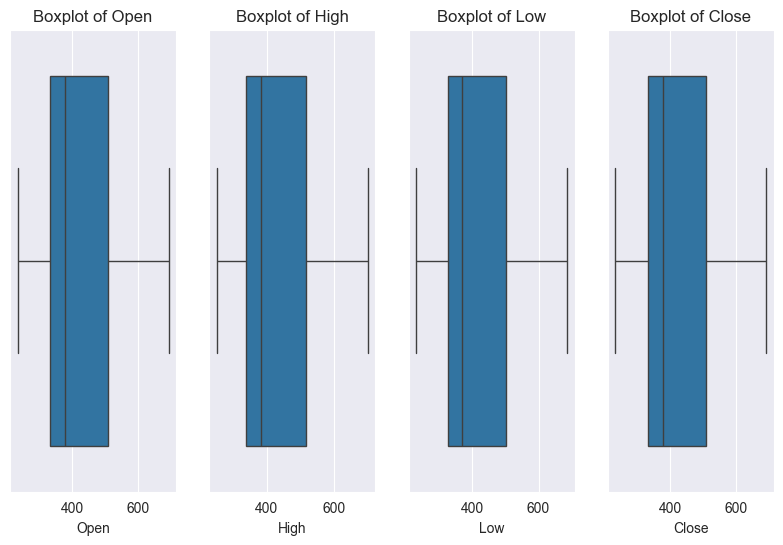

In [9]:
# OUTLIER DETECTION
numeric_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
print("\nPerforming Outlier Detection...")
outlier_analysis = comprehensive_outlier_detection(df, numeric_columns)

2. DATA QUALITY ASSESSMENT

In [10]:
# Check for missing values
def check_missing_values(df):
    total_count = df.count()
    missing_counts = []
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        missing_counts.append((column, missing_count, (missing_count/total_count)*100))
    
    for column, count, percentage in missing_counts:
        print(f"{column}: {count} missing values ({percentage:.2f}%)")

print("\nMissing Values:")
check_missing_values(df)


Missing Values:
Date: 0 missing values (0.00%)
Open: 0 missing values (0.00%)
High: 0 missing values (0.00%)
Low: 0 missing values (0.00%)
Close: 0 missing values (0.00%)
Adj Close: 0 missing values (0.00%)
Volume: 0 missing values (0.00%)


In [11]:
# Check for duplicates
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"\nNumber of Duplicate Records: {duplicate_count}")


Number of Duplicate Records: 0


3. DATA PREPROCESSING

In [12]:
# Convert Date column to proper date type
df = df.withColumn("Date", col("Date").cast(DateType()))

In [13]:
# Convert string columns to double where appropriate
for column in numeric_columns:
    df = df.withColumn(column, col(column).cast(DoubleType()))

In [14]:
# Handle missing values with interpolation
# Note: In Spark, we'll use forward fill as a simple alternative to interpolation
window_spec = Window.orderBy("Date")
for column in numeric_columns:
    df = df.withColumn(column, 
                      coalesce(col(column), 
                              last(col(column), True).over(window_spec)))

4. DESCRIPTIVE STATISTICS

In [18]:
# Calculate summary statistics
from pyspark.sql.functions import mean, stddev, min as spark_min, max as spark_max

stats_list = []
for c in numeric_columns:
    stats_list.extend([
        mean(col(c)).alias(f"{c}_mean"),
        stddev(col(c)).alias(f"{c}_stddev"),
        spark_min(col(c)).alias(f"{c}_min"),
        spark_max(col(c)).alias(f"{c}_max")
    ])

summary_stats = df.select(stats_list).toPandas()

print("\nDescriptive Statistics:")
print(summary_stats)


Descriptive Statistics:
    Open_mean  Open_stddev    Open_min    Open_max   High_mean  High_stddev  \
0  419.059673   108.537532  233.919998  692.349976  425.320703    109.26296   

     High_min   High_max    Low_mean  Low_stddev  ...   Close_min   Close_max  \
0  250.649994  700.98999  412.374044  107.555867  ...  233.880005  691.690002   

   Adj Close_mean  Adj Close_stddev  Adj Close_min  Adj Close_max  \
0      419.000733        108.289999     233.880005     691.690002   

    Volume_mean  Volume_stddev  Volume_min  Volume_max  
0  7.570685e+06   5.465535e+06   1144000.0  58904300.0  

[1 rows x 24 columns]


5. DISTRIBUTION ANALYSIS

In [22]:
# Convert to pandas for visualization
pandas_df = df.toPandas()

In [23]:
# Create distribution plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=pandas_df, x=col, kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.savefig('distribution_plots/histograms.png')
plt.close()

In [25]:
# Create box plots
plt.figure(figsize=(15, 5))
pandas_df[numeric_columns].boxplot()
plt.title('Box Plot of Numeric Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribution_plots/boxplots.png')
plt.close()

6. RELATIONSHIP EXPLORATION

In [26]:
# Calculate correlations
correlations = []
for col1 in numeric_columns:
    for col2 in numeric_columns:
        correlation = df.stat.corr(col1, col2)
        correlations.append((col1, col2, correlation))

In [29]:
# Convert correlations to a pandas DataFrame for visualization
correlation_df = pd.DataFrame(correlations, columns=['Column1', 'Column2', 'Correlation'])
correlation_matrix = correlation_df.pivot(index='Column1', columns='Column2', values='Correlation')

In [30]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('distribution_plots/correlation_heatmap.png')
plt.close()

In [31]:
# Save processed data
df.write.mode("overwrite").csv("dataset/preprocessed_spark_data.csv", header=True)
print("\nPreprocessed data saved to 'dataset/preprocessed_spark_data.csv'")


Preprocessed data saved to 'dataset/preprocessed_spark_data.csv'


In [32]:
# Stop Spark session
spark.stop()